In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import mlflow
from typing import Tuple, List

import sys
import os

sys.path.append(os.path.abspath(os.path.join("../src")))
from experiment import run_experiment
from helper_functions import generate_random_string

In [2]:
mlflow.set_tracking_uri("http://localhost:5001")

In [25]:
df = pd.read_csv("../data/raw_games.csv").dropna()

In [27]:
df = df[df["div"] == "E0"]

In [4]:
total_probs = (1 / df["b365h"]) + (1 / df["b365d"]) + (1 / df["b365a"])
df["bookies_prob"] = 1 / df["b365h"] / total_probs

In [5]:
teams = pd.concat([df["hometeam"], df["awayteam"]]).unique()
TEST_SEASONS = ["23_24", "24_25"]
VAL_SEASONS = ["21_22", "22_23"]

## Calculating Elo

We can use the [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) as a feature in our models. We can also use it to assess how "impressive" a victory is which is useful for quantifying form. 

In [6]:
def expected_score(rating_1, rating_2):
    return 1 / (1 + 10 ** ((rating_2 - rating_1) / 400))

In [7]:
elo_ratings = {team: 1500 for team in teams}
K = 20

elo_h_before = []
elo_a_before = []
elo_prob_h = []
elo_prob_a = []

for idx, row in df.iterrows():
    elo_h = elo_ratings[row["hometeam"]]
    elow_a = elo_ratings[row["awayteam"]]

    elo_h_before.append(elo_h)
    elo_a_before.append(elow_a)

    exp_h = expected_score(elo_h, elow_a)
    exp_a = expected_score(elow_a, elo_h)
    elo_prob_h.append(exp_h)
    elo_prob_a.append(exp_a)

    score_home = int(row["ftr"] == "H") + 0.5 * int(row["ftr"] == "D")
    score_away = int(row["ftr"] == "A") + 0.5 * int(row["ftr"] == "D")

    elo_h_new = elo_h + K * (score_home - exp_h)
    elo_a_new = elow_a + K * (score_away - exp_a)

    elo_ratings[row["hometeam"]] = elo_h_new
    elo_ratings[row["awayteam"]] = elo_a_new

df["elo_h_before"] = elo_h_before
df["elo_a_before"] = elo_a_before
df["elo_prob_h"] = elo_prob_h
df["elo_prob_a"] = elo_prob_a

ratings_df = pd.DataFrame(list(elo_ratings.items()), columns=["Team", "Elo"])
ratings_df = (
    ratings_df.sort_values(by="Elo", ascending=False)
    .reset_index()
    .drop(columns=["index"])
)

print("\nTop 5:")
print(ratings_df.head(5))
print("\nBottom 5:")
print(ratings_df.tail(5))


Top 5:
        Team          Elo
0  Liverpool  1794.024722
1    Arsenal  1787.939045
2   Man City  1767.358485
3    Chelsea  1645.655386
4  Newcastle  1630.438552

Bottom 5:
                Team          Elo
36               QPR  1380.760456
37       Southampton  1365.110820
38      Huddersfield  1359.967925
39  Sheffield United  1359.713392
40           Norwich  1348.832906


Elo score uses an expected score mechanism which is between zero and one. We can treat this as a home win probability prediction to estimate the predictability of Elo. The expected scores has already been added to the dataframe in the Elo calculation. Below we plot an ROC using the expected score to compare the predictability of Elo against that of the bookies odds.

In [8]:
df["h_win"] = (df["ftr"] == "H").astype(int)

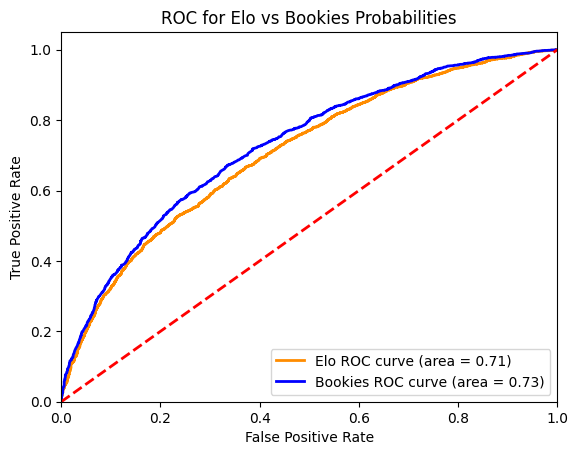

In [9]:
elo_fpr, elo_tpr, elo_thresholds = roc_curve(df["h_win"], df["elo_prob_h"])
elo_roc_auc = auc(elo_fpr, elo_tpr)

bookies_fpr, bookies_tpr, bookies_thresholds = roc_curve(
    df["h_win"], df["bookies_prob"]
)
bookies_roc_auc = auc(bookies_fpr, bookies_tpr)

plt.figure()
plt.plot(
    elo_fpr,
    elo_tpr,
    color="darkorange",
    lw=2,
    label="Elo ROC curve (area = %0.2f)" % elo_roc_auc,
)
plt.plot(
    bookies_fpr,
    bookies_tpr,
    color="blue",
    lw=2,
    label="Bookies ROC curve (area = %0.2f)" % bookies_roc_auc,
)
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Elo vs Bookies Probabilities")
plt.legend(loc="lower right")
plt.show()

## Data Prep Function for Experiments

In [10]:
def prep_train_val(
    data: pd.DataFrame, features: List[str], target: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data = data.copy()

    columns = (
        features
        + [target]
        + ["game_num_h", "game_num_a", "bookies_prob", "season"]
    )

    data = data[columns]
    data = data[
        ~data["game_num_h"].isin(range(6)) & ~data["game_num_a"].isin(range(6))
    ]
    data = data[
        ~data["game_num_h"].isin(range(6)) & ~data["game_num_a"].isin(range(6))
    ]
    data = data[data["season"] != "10_11"]

    train = data[~data["season"].isin(TEST_SEASONS + VAL_SEASONS)]
    val = data[data["season"].isin(VAL_SEASONS)]

    train = train.drop(columns=["game_num_h", "game_num_a", "bookies_prob"])
    val = val.drop(columns=["game_num_h", "game_num_a"])

    return train, val

## Experiment 1: Using Elo Alone to Predict Home Wins

First we will try to predict the probability of a home win using home and away Elo ratings as sole features in the model.

In [11]:
train_1, val_1 = prep_train_val(df, ["elo_prob_h", "elo_prob_a"], "h_win")

In [12]:
exp_1_run_id = generate_random_string()
print(f"Experiment run ID: {exp_1_run_id}")

run_experiment(
    "form-feature-exploration",
    train_1,
    val_1,
    hidden_units=None,
    learning_rate=0.001,
    num_epochs=10000,
    num_samples=1000,
    num_batches=1,
    league_tag="EPL",
    run_id=exp_1_run_id,
    run_description="elo only",
    return_model=False,
)

Experiment run ID: A67QO15T


Validation Output Sampling Progress: 100%|██████████| 1000/1000 [00:23<00:00, 42.48it/s]


🏃 View run treasured-stag-608 at: http://localhost:5001/#/experiments/2/runs/ba761fd8f1b149dcbdd1d28c8518482b
🧪 View experiment at: http://localhost:5001/#/experiments/2


In [13]:
run_data_1 = mlflow.search_runs(
    filter_string=f"tags.run_id = '{exp_1_run_id}'"
)[
    [
        "tags.run_description",
        "metrics.train_auc",
        "metrics.val_auc",
        "metrics.train_mse",
        "metrics.val_mse",
    ]
]
run_data_1

,tags.run_description,metrics.train_auc,metrics.val_auc,metrics.train_mse,metrics.val_mse
0,elo only,0.713245,0.712972,0.213969,0.214224


## Experiment 2: Using Number of Wins in Last 5 Games as a Form Feature

One way to represent form is by looking at the results of the last 5 games. As a starting point, we can simplify this even further by taking an aggregation of the last 5 results for each team and use this as a feature in our model. 

We will count a win as 1 and a draw as 0.5, in line with the Elo quantification and sum these values over the previous 5 games. The form will reset at the start of each season. 

In [14]:
teams_last_5 = {team: [np.nan] * 5 for team in teams}

home_last_5 = []
away_last_5 = []

for idx, row in df.iterrows():
    home = row["hometeam"]
    away = row["awayteam"]

    if row["game_num_h"] == 1:
        teams_last_5[home] = [np.nan] * 5
    home_last_5.append(teams_last_5[home].copy())

    if row["game_num_a"] == 1:
        teams_last_5[away] = [np.nan] * 5
    away_last_5.append(teams_last_5[away].copy())

    teams_last_5[home].pop(0)
    teams_last_5[away].pop(0)

    teams_last_5[home].append(
        int(row["ftr"] == "H") + 0.5 * int(row["ftr"] == "D")
    )
    teams_last_5[away].append(
        int(row["ftr"] == "A") + 0.5 * int(row["ftr"] == "D")
    )

for i in range(5):
    df[f"result_-{5-i}_h"] = [lst[i] for lst in home_last_5]
    df[f"result_-{5-i}_a"] = [lst[i] for lst in away_last_5]

In [15]:
tot_game_filter = (df["hometeam"] == "Tottenham") | (
    df["awayteam"] == "Tottenham"
)
result_cols = [f"result_-{5-i}_{g}" for g in ["h", "a"] for i in range(5)]
df.loc[
    tot_game_filter,
    ["hometeam", "awayteam", "game_num_h", "ftr"] + result_cols,
]

,hometeam,awayteam,game_num_h,ftr,result_-5_h,result_-4_h,result_-3_h,result_-2_h,result_-1_h,result_-5_a,result_-4_a,result_-3_a,result_-2_a,result_-1_a
5,Tottenham,Man City,1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Stoke,Tottenham,2,A,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.5
24,Tottenham,Wigan,3,A,NaN,NaN,NaN,0.5,1.0,NaN,NaN,NaN,0.0,0.0
35,West Brom,Tottenham,4,D,NaN,NaN,0.0,1.0,0.0,NaN,NaN,0.5,1.0,0.0
45,Tottenham,Wolves,5,H,NaN,0.5,1.0,0.0,0.5,NaN,1.0,0.5,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5527,Arsenal,Tottenham,21,H,0.5,1.0,1.0,1.0,0.5,1.0,0.0,0.0,0.5,0.0
5535,Everton,Tottenham,21,H,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
5547,Tottenham,Leicester,23,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5556,Brentford,Tottenham,24,A,0.0,1.0,0.5,0.0,1.0,0.5,0.0,0.0,0.0,0.0


In [16]:
df["sum_last_5_h"] = df[[f"result_-{5-i}_h" for i in range(5)]].sum(axis=1)
df["sum_last_5_a"] = df[[f"result_-{5-i}_a" for i in range(5)]].sum(axis=1)

In [17]:
train_2, val_2 = prep_train_val(
    df, ["elo_prob_h", "elo_prob_a", "sum_last_5_h", "sum_last_5_a"], "h_win"
)

In [18]:
exp_2_run_id = generate_random_string()
print(f"Experiment run ID: {exp_2_run_id}")

run_experiment(
    "form-feature-exploration",
    train_2,
    val_2,
    hidden_units=None,
    learning_rate=0.001,
    num_epochs=10000,
    num_samples=1000,
    num_batches=1,
    league_tag="EPL",
    run_id=exp_2_run_id,
    run_description="elo + last 5 games summed",
    return_model=False,
)

Experiment run ID: DARTbPGv


Validation Output Sampling Progress: 100%|██████████| 1000/1000 [00:24<00:00, 41.54it/s]


🏃 View run dazzling-zebra-632 at: http://localhost:5001/#/experiments/2/runs/fbe18695f5ab421e808236abd0071965
🧪 View experiment at: http://localhost:5001/#/experiments/2


In [19]:
run_data_2 = mlflow.search_runs(
    filter_string=f"tags.run_id = '{exp_2_run_id}'"
)[
    [
        "tags.run_description",
        "metrics.train_auc",
        "metrics.val_auc",
        "metrics.train_mse",
        "metrics.val_mse",
        "metrics.val_mse_diff",
        "metrics.val_auc_diff",
    ]
]

all_runs_data = pd.concat([run_data_2, run_data_1])
all_runs_data

,tags.run_description,metrics.train_auc,metrics.val_auc,metrics.train_mse,metrics.val_mse
0,elo + last 5 games summed,0.713265,0.713009,0.213936,0.214197
0,elo only,0.713245,0.712972,0.213969,0.214224


This form feature does not seem to have significantly improved the model. This may be because the information is already encoded in the Elo.

## Experiment 3: Passing in Last 5 Games Separately

Rather than providing the last 5 results as an aggregation, we will try passing in all of the results as features. This way the model will "decide" the importance of each game during training.

In [20]:
train_3, val_3 = prep_train_val(
    df, ["elo_prob_h", "elo_prob_a"] + result_cols, "h_win"
)

In [21]:
exp_3_run_id = generate_random_string()
print(f"Experiment run ID: {exp_3_run_id}")

run_experiment(
    "form-feature-exploration",
    train_3,
    val_3,
    hidden_units=None,
    learning_rate=0.001,
    num_epochs=10000,
    num_samples=1000,
    num_batches=1,
    league_tag="EPL",
    run_id=exp_3_run_id,
    run_description="elo + last 5 games individual",
    return_model=False,
)

Experiment run ID: 4ccRAQ9t


Validation Output Sampling Progress: 100%|██████████| 1000/1000 [00:25<00:00, 39.70it/s]


🏃 View run upbeat-gnat-40 at: http://localhost:5001/#/experiments/2/runs/192c6698ba4d4353be6dc4b5fe54031a
🧪 View experiment at: http://localhost:5001/#/experiments/2


In [23]:
run_data_3 = mlflow.search_runs(
    filter_string=f"tags.run_id = '{exp_3_run_id}'"
)[
    [
        "tags.run_description",
        "metrics.train_auc",
        "metrics.val_auc",
        "metrics.train_mse",
        "metrics.val_mse",
        "metrics.val_mse_diff",
        "metrics.val_auc_diff",
    ]
]

all_runs_data = pd.concat([run_data_3, all_runs_data])
all_runs_data

,tags.run_description,metrics.train_auc,metrics.val_auc,metrics.train_mse,metrics.val_mse
0,elo + last 5 games individual,0.713635,0.713175,0.213810,0.214004
0,elo + last 5 games summed,0.713265,0.713009,0.213936,0.214197
0,elo only,0.713245,0.712972,0.213969,0.214224


We observe no significant improvement from this experiment.

## Experiment 4a: Factoring Quality of Opponents Faced

Alongside the results, we will pass in the ELO of each of the teams faced as this should give the model cotext of how much a team under/over achieved in their recent games

## Experiment 4b: Adding Hidden Layers

Hidden layers allow features to interact, potentially boosting the performance of the model.